In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.core.pylabtools import figsize
%matplotlib inline

In [2]:
#utils
import warnings
import jpholiday
from datetime import datetime, timedelta

#warning ignore
def ignore_warning():
    warnings.filterwarnings('ignore')
    
#start_date から end_date まで一定間隔開けた日付を取得
def get_arange_datetime(start_date, end_date, **kwargs):
    return np.arange(start_date, end_date, timedelta(**kwargs)).astype(datetime)

#結束してる日付を補完する.
def insert_nan_dropped_date(X_dropped, ideal_dates):
    X_dropped = X_dropped.T.copy()
    for i_date in ideal_dates:
        if i_date not in X_dropped.columns:
            X_dropped[i_date] = np.nan
    return X_dropped.T.sort_index()        

def get_after_day(start_date, **kwargs):
    return start_date + timedelta(**kwargs)

#get_holiday
def get_holiday(date):
    if jpholiday.is_holiday_name(date):
        return 1
    else:
        return 0
    
def get_weekend(date):
    if date.dayofweek >= 5:
        return 1
    else:
        return 0

# データ読み込み

In [3]:
#データ読み込み
sample_data = pd.read_csv("./data/nikkei_stock_average_daily_jp.csv", encoding="shift-jis")

#データ整形
sample_data.columns = ["date", "end", "start", "high", "low"]
sample_data = sample_data[:-1]

#indexを日付に
sample_data.index = pd.to_datetime(sample_data["date"])
sample_data       = sample_data.drop(["date"], axis=1)

In [4]:
sample_data.head()

,end,start,high,low
date,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22
2015-01-06,16883.19,17101.58,17111.36,16881.73
2015-01-07,16885.33,16808.26,16974.61,16808.26
2015-01-08,17167.10,17067.40,17243.71,17016.09
2015-01-09,17197.73,17318.74,17342.65,17129.53


/Users/Chang/.pyenv/versions/3.5.1/envs/python351/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


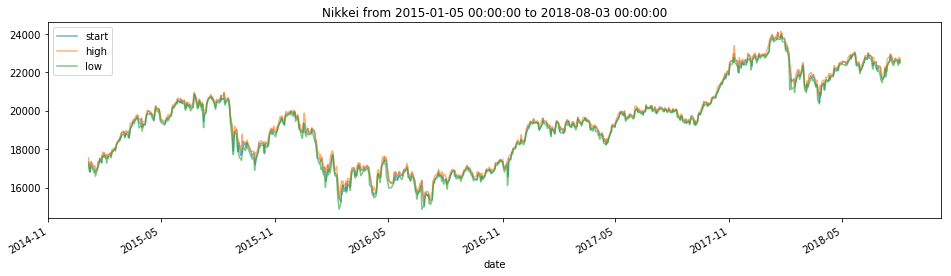

In [5]:
#plot
figsize(20, 4)
start_idx, end_idx = sample_data.index[0], sample_data.index[-1]
sample_data.plot(y= ["start", "high", "low"], 
                 figsize=(16,4), 
                 alpha = 0.6, title="Nikkei from %s to %s"%(start_idx, end_idx))

# 前処理

In [6]:
#dropしたデータを作成
drop_row = np.random.choice(range(len(sample_data)), replace=False, size=400)
drop_row = np.sort(drop_row)
X_dropped = sample_data.iloc[drop_row,:]

In [7]:
X_dropped.head()

,end,start,high,low
date,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22
2015-01-07,16885.33,16808.26,16974.61,16808.26
2015-01-08,17167.10,17067.40,17243.71,17016.09
2015-01-09,17197.73,17318.74,17342.65,17129.53
2015-01-14,16795.96,16961.82,17036.72,16770.56


In [8]:
s_date = np.min(X_dropped.index)
e_date = np.max(X_dropped.index)

In [9]:
ideal_dates = get_arange_datetime(s_date, e_date, days=1)
X_dropped = insert_nan_dropped_date(X_dropped, ideal_dates)

In [10]:
X_dropped.head()

,end,start,high,low
date,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22
2015-01-06,NaN,NaN,NaN,NaN
2015-01-07,16885.33,16808.26,16974.61,16808.26
2015-01-08,17167.10,17067.40,17243.71,17016.09
2015-01-09,17197.73,17318.74,17342.65,17129.53


# モデリング

In [165]:
s_date = np.min(sample_data.index)
e_date = np.max(sample_data.index)
ideal_dates = get_arange_datetime(s_date, e_date, days=1)
sample_data = insert_nan_dropped_date(sample_data, ideal_dates)
sample_data = sample_data.fillna(0)

In [11]:
sample_data["holiday"] = [get_holiday(date.date()) for date in sample_data.index]
sample_data["weekend"] = [get_weekend(date) for date in sample_data.index]

In [12]:
X_train = sample_data[sample_data.index < datetime(2018,4,1)]
X_valid = sample_data[sample_data.index >= datetime(2018,4,1)]

## [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

In [13]:
from fbprophet import Prophet
X_train_prophet = X_train.reset_index().rename(columns={'end':'y', 'date':'ds'})
X_valid_prophet = X_valid.reset_index().rename(columns={'end':'y', 'date':'ds'})

In [14]:
holidays = pd.DataFrame(columns=["holiday","ds", "lower_window", "upper_window"])
holidays["ds"] = [d for d in sample_data.index[sample_data["holiday"] == 1]]
holidays["holiday"] = "holiday"
holidays["lower_window"] = 0
holidays["upper_window"] = 0

In [15]:
#X_train_prophet['cap'] = 6 #上限
#X_train_prophet['floor'] = 0. #下限
model = Prophet(growth='linear', daily_seasonality=False, weekly_seasonality=True, 
                yearly_seasonality=True, holidays=holidays) #growth = logistic
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model = model.fit(X_train_prophet)

In [16]:
# Python
pred = model.make_future_dataframe(periods=len(X_valid_prophet))
pred = model.predict(pred)

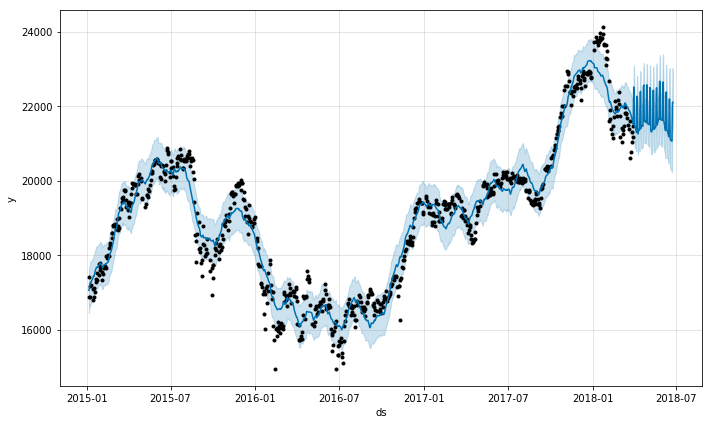

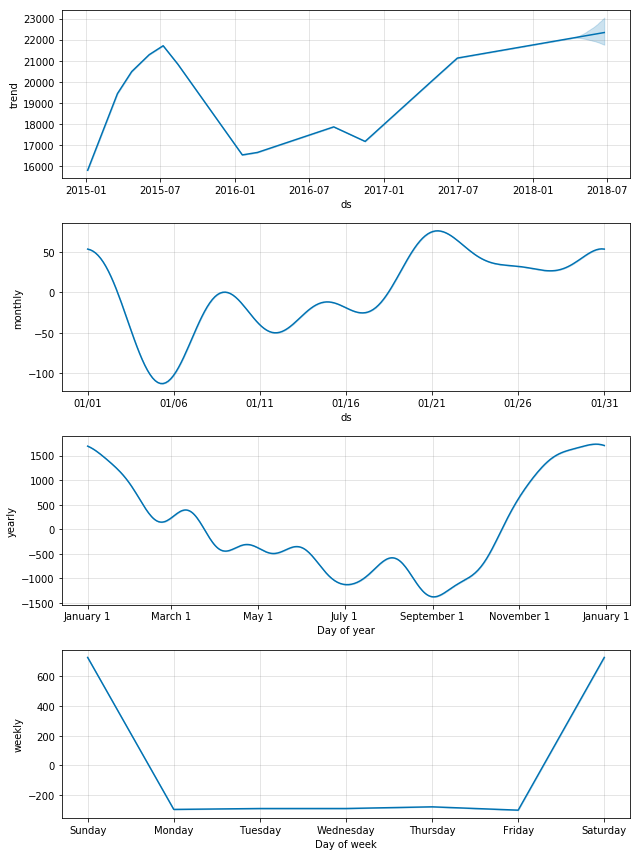

In [17]:
fig1 = model.plot(pred)
fig2 = model.plot_components(pred)

## moving average

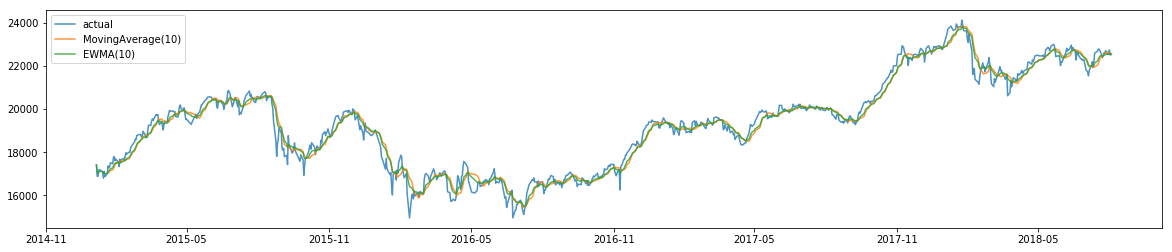

In [30]:
ignore_warning()
plt.plot(sample_data["end"], label="actual", alpha = 0.8)
plt.plot(pd.rolling_mean(sample_data["end"], 10), label="MovingAverage(10)", alpha = 0.8)
plt.plot(pd.ewma(sample_data["end"], span=10), label = "EWMA(10)", alpha = 0.8)
plt.legend()

In [61]:
def reverse_moving_average(data , origin, span = 3):
    assert len(origin) == span-1, "span - 1のlistデータが必要"
    reversed_data = data.copy()
    reversed_data[:(span-1)] = origin
    for idx in range(span-1,len(reversed_data)):
        reversed_data[idx] = reversed_data[idx]*span - np.sum(reversed_data[(idx-(span-1)):idx])
    return reversed_data

In [50]:
data = pd.rolling_mean(sample_data["end"], 3).values

## Bayeisan pydlm

In [72]:
from pydlm import dlm, trend, seasonality
# A linear trend
linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)
# A seasonality
seasonal52 = seasonality(period=52, discount=0.99, name='seasonal52', w=10)
# Build a simple dlm
simple_dlm = dlm(X_train["end"]) + linear_trend + seasonal52

Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...


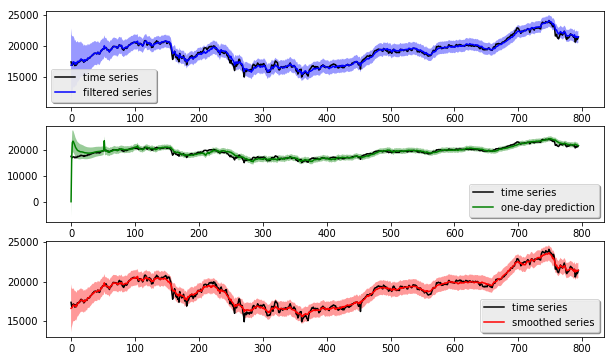

In [75]:
figsize(10,6)
simple_dlm.fit()
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

## Machine Learning

In [84]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ARDRegression, ElasticNet, HuberRegressor, Lasso, PassiveAggressiveRegressor, RANSACRegressor, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

In [85]:
regs = [AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, 
        RandomForestRegressor, ARDRegression, ElasticNet, HuberRegressor, Lasso, PassiveAggressiveRegressor, 
        RANSACRegressor, LinearRegression, KNeighborsRegressor, MLPRegressor, LinearSVR, SVR, DecisionTreeRegressor, ExtraTreeRegressor]

In [94]:
y = X_train["end"].values
X = X_train.drop(["end"], axis=1)
regs[0]().fit(X=X, y=y)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

## LSTM RNN

In [31]:
#VAR model

In [ ]:
#dynamic data

Epoch 1/100
0s - loss: 0.0340
Epoch 2/100
0s - loss: 0.0149
Epoch 3/100
0s - loss: 0.0115
Epoch 4/100
0s - loss: 0.0107
Epoch 5/100
0s - loss: 0.0097
Epoch 6/100
0s - loss: 0.0089
Epoch 7/100
0s - loss: 0.0080
Epoch 8/100
0s - loss: 0.0072
Epoch 9/100
0s - loss: 0.0063
Epoch 10/100
0s - loss: 0.0055
Epoch 11/100
0s - loss: 0.0048
Epoch 12/100
0s - loss: 0.0042
Epoch 13/100
0s - loss: 0.0037
Epoch 14/100
0s - loss: 0.0033
Epoch 15/100
0s - loss: 0.0029
Epoch 16/100
0s - loss: 0.0027
Epoch 17/100
0s - loss: 0.0025
Epoch 18/100
0s - loss: 0.0023
Epoch 19/100
0s - loss: 0.0022
Epoch 20/100
0s - loss: 0.0021
Epoch 21/100
0s - loss: 0.0021
Epoch 22/100
0s - loss: 0.0021
Epoch 23/100
0s - loss: 0.0021
Epoch 24/100
0s - loss: 0.0021
Epoch 25/100
0s - loss: 0.0020
Epoch 26/100
0s - loss: 0.0021
Epoch 27/100
0s - loss: 0.0021
Epoch 28/100
0s - loss: 0.0020
Epoch 29/100
0s - loss: 0.0020
Epoch 30/100
0s - loss: 0.0021
Epoch 31/100
0s - loss: 0.0021
Epoch 32/100
0s - loss: 0.0020
Epoch 33/100
0s -

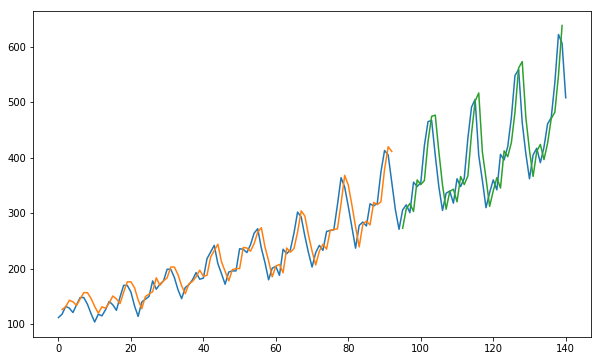

In [104]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('https://raw.githubusercontent.com/gcarq/keras-timeseries-prediction/master/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
#Deep Learning

In [ ]:
#1d CNN

In [ ]:
import statsmodels.api as sm
#ARIMA model
fit1 = sm.tsa.statespace.SARIMAX(sample_data["start"], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()

In [ ]:
#Fourir Transform

In [ ]:
def get_slide_pred():
    model.fit()
    model.predict(sample_data[:100])

In [1]:
import plotly.offline as ply
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
%matplotlib inline

In [2]:
ply.init_notebook_mode(connected=True)

In [ ]:
# slide fit